In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
import tensorflow as tf

# paths
root = "MOBIUS"
img_root = os.path.join(root, "Images")
resize_to = (512, 512)


2025-11-01 01:52:55.932502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-01 01:52:58.646460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


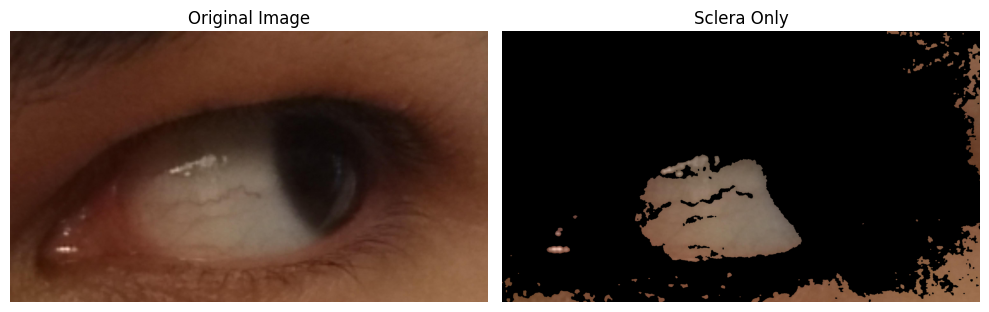

In [2]:
IMG_PATH = "MOBIUS/Images/1/1_1i_Ll_1.jpg"   # <- put your image path here
img = cv2.imread(IMG_PATH)  # BGR format
if img is None:
    raise FileNotFoundError(f"Image not found at {IMG_PATH}")

# Convert to LAB color space and threshold the L channel
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
L = lab[:, :, 0]
L = clahe.apply(L)
_, sclera_mask = cv2.threshold(L, 130, 255, cv2.THRESH_BINARY)

# Morphological operations to clean up the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
sclera_mask = cv2.morphologyEx(sclera_mask, cv2.MORPH_CLOSE, kernel)
sclera_mask = cv2.morphologyEx(sclera_mask, cv2.MORPH_OPEN, kernel)

# Apply the mask to the original image
sclera_only = cv2.bitwise_and(img, img, mask=sclera_mask)

# Convert to RGB for visualization
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sclera_rgb = cv2.cvtColor(sclera_only, cv2.COLOR_BGR2RGB)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sclera_rgb)
plt.title("Sclera Only")
plt.axis("off")

plt.tight_layout()
plt.show()

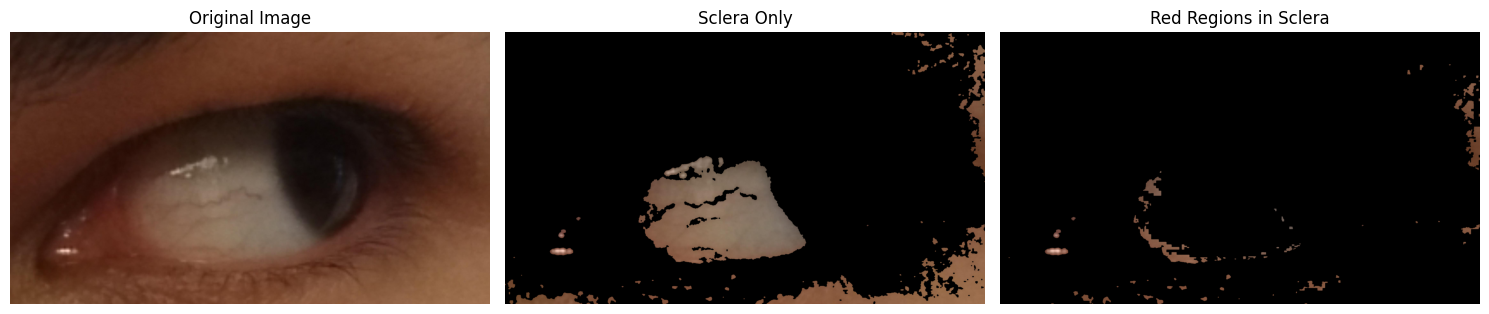

In [3]:
hsv = cv2.cvtColor(sclera_only, cv2.COLOR_BGR2HSV)

# Define red color ranges in HSV
lower_red1 = np.array([0, 50, 50])   # Lower range of red (hue 0-10)
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 50, 50]) # Upper range of red (hue 170-180)
upper_red2 = np.array([180, 255, 255])

# Create masks for red regions
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask_red1, mask_red2)

# Apply morphological operations to clean up the red mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)
red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

# Apply the red mask to the sclera region
red_regions = cv2.bitwise_and(sclera_only, sclera_only, mask=red_mask)

# Convert to RGB for visualization
red_regions_rgb = cv2.cvtColor(red_regions, cv2.COLOR_BGR2RGB)

# Display the results
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sclera_rgb)
plt.title("Sclera Only")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(red_regions_rgb)
plt.title("Red Regions in Sclera")
plt.axis("off")

plt.tight_layout()
plt.show()

## Alternate approach

Alternative is to use the MOBIUS dataset efficiently. The steps are:
1. Segment the various parts of the eye
2. Detect the Sclera and segment it
3. Use the segmented sclera and extract the red parts of the eye in sclera 

In [4]:
import os

print("Images Directory:")
print(os.listdir("MOBIUS/Images"))

print("\nMasks Directory:")
print(os.listdir("MOBIUS/Masks"))

print("\nContents of MOBIUS/Images/1:")
print(os.listdir("MOBIUS/Images/1"))

print("\nContents of MOBIUS/Masks/1:")
print(os.listdir("MOBIUS/Masks/1"))

Images Directory:
['97', '75', '76', '35', '68', '74', '93', '10', '18', '77', '51', '57', '88', '63', '26', '98', '52', '84', '22', '56', '50', '5', '46', '29', '62', '91', '78', '16', '39', '33', '71', '90', '2', '28', '61', '80', '48', '15', '94', '27', '64', '3', '36', '70', '8', '87', '25', '6', '59', '34', '99', '92', '38', '73', '31', '20', '86', '43', '40', '100', '96', '12', '47', '24', '69', '85', '89', '82', '54', '66', '30', '9', '79', '53', '21', '45', '60', '81', '4', '23', '65', '1', '14', '72', '37', '55', '58', '13', '67', '95', '7', '44', '19', '83', '32', '41', '11', '17', '49', '42']

Masks Directory:
['35', '10', '18', '26', '22', '5', '29', '16', '33', '2', '28', '15', '27', '3', '8', '25', '6', '34', '31', '20', '12', '24', '30', '9', '21', '4', '23', '1', '14', '13', '7', '19', '32', '11', '17']

Contents of MOBIUS/Images/1:
['1_2n_Ru_2.jpg', '1_1i_Rl_2.jpg', '1_2i_Rs_1.jpg', '1_2i_Ll_2.jpg', '1_3n_Lu_1.jpg', '1_2p_Ls_bad.jpg', '1_2i_Ls_1.jpg', '1_3p_Lu_2.jpg', 

In [9]:
import tensorflow as tf
import numpy as np
import cv2, os
from sklearn.model_selection import train_test_split
from tqdm import tqdm

IMG_SIZE = (128, 128)

def load_data(img_root, mask_root):
    X, Y = [], []
    print(f"Loading data from {img_root} and {mask_root}...")
    
    for sub in tqdm(sorted(os.listdir(img_root))[:20], desc="Processing subdirectories"):  # Iterate through first 50 subdirectories
        img_dir = os.path.join(img_root, sub)
        mask_dir = os.path.join(mask_root, sub)
        
        # Check if both image and mask subdirectories exist
        if not os.path.exists(mask_dir):
            #print(f"Warning: Mask directory {mask_dir} does not exist. Skipping...")
            continue

        print(f"Processing directory: {img_dir}")
        for f in tqdm(sorted(os.listdir(img_dir)), desc=f"Processing files in {sub}", leave=False):  # Iterate through files in the image subdirectory
            if "_bad" in f:  # Skip files with '_bad' in their names
                #print(f"Skipping file {f} as it is marked as 'bad'.")
                continue

            if f.lower().endswith((".jpg", ".png")):
                img_path = os.path.join(img_dir, f)
                # Adjusted mask_path logic to match your naming convention
                mask_path = os.path.join(mask_dir, f.rsplit('.', 1)[0] + '.png')
                
                # Check if the corresponding mask file exists
                if not os.path.exists(mask_path):
                    #print(f"Warning: Mask file {mask_path} not found for image {img_path}. Skipping...")
                    continue

                # Read and preprocess the image and mask
                img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
                mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

                # Convert mask to class indices: 0-background, 1-sclera(R), 2-iris(B)
                lbl = np.zeros(mask.shape[:2], np.uint8)
                lbl[(mask[:, :, 0] > 100) & (mask[:, :, 1] < 50) & (mask[:, :, 2] < 50)] = 1  # Sclera (Red)
                lbl[(mask[:, :, 2] > 100) & (mask[:, :, 0] < 50) & (mask[:, :, 1] < 50)] = 2  # Iris (Blue)

                X.append(img)
                Y.append(lbl)

    # Ensure data was loaded
    if not X or not Y:
        raise ValueError("No data loaded. Please check the directory structure and file naming.")
    
    # Convert to numpy arrays and normalize
    X = np.array(X, np.float32) / 255.0
    Y = np.array(Y, np.uint8)
    return X, Y

# Load data
X, Y = load_data("MOBIUS/Images", "MOBIUS/Masks")
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

print("Train:", x_train.shape, "Val:", x_val.shape)

Loading data from MOBIUS/Images and MOBIUS/Masks...


Processing subdirectories:   0%|          | 0/20 [00:00<?, ?it/s]

Processing directory: MOBIUS/Images/1


Processing subdirectories:   5%|▌         | 1/20 [00:12<03:53, 12.29s/it]

Processing directory: MOBIUS/Images/10


Processing subdirectories:  10%|█         | 2/20 [00:16<02:11,  7.30s/it]

Processing directory: MOBIUS/Images/11


Processing subdirectories:  20%|██        | 4/20 [00:27<01:43,  6.45s/it]

Processing directory: MOBIUS/Images/12


Processing subdirectories:  25%|██▌       | 5/20 [00:35<01:43,  6.93s/it]

Processing directory: MOBIUS/Images/13


Processing subdirectories:  30%|███       | 6/20 [00:48<01:59,  8.51s/it]

Processing directory: MOBIUS/Images/14


Processing subdirectories:  35%|███▌      | 7/20 [01:00<02:04,  9.57s/it]

Processing directory: MOBIUS/Images/15


Processing subdirectories:  40%|████      | 8/20 [01:03<01:34,  7.86s/it]

Processing directory: MOBIUS/Images/16


Processing subdirectories:  45%|████▌     | 9/20 [01:12<01:27,  7.92s/it]

Processing directory: MOBIUS/Images/17


Processing subdirectories:  50%|█████     | 10/20 [01:22<01:26,  8.62s/it]

Processing directory: MOBIUS/Images/18


Processing subdirectories:  55%|█████▌    | 11/20 [01:32<01:20,  8.96s/it]

Processing directory: MOBIUS/Images/19


Processing subdirectories:  60%|██████    | 12/20 [01:43<01:18,  9.75s/it]

Processing directory: MOBIUS/Images/2


Processing subdirectories:  65%|██████▌   | 13/20 [01:55<01:13, 10.46s/it]

Processing directory: MOBIUS/Images/20


Processing subdirectories:  70%|███████   | 14/20 [01:59<00:50,  8.47s/it]

Processing directory: MOBIUS/Images/21


Processing subdirectories:  75%|███████▌  | 15/20 [02:11<00:47,  9.47s/it]

Processing directory: MOBIUS/Images/22


Processing subdirectories:  80%|████████  | 16/20 [02:15<00:31,  7.76s/it]

Processing directory: MOBIUS/Images/23


Processing subdirectories:  85%|████████▌ | 17/20 [02:18<00:19,  6.58s/it]

Processing directory: MOBIUS/Images/24


Processing subdirectories:  90%|█████████ | 18/20 [02:30<00:16,  8.12s/it]

Processing directory: MOBIUS/Images/25


Processing subdirectories:  95%|█████████▌| 19/20 [02:42<00:09,  9.25s/it]

Processing directory: MOBIUS/Images/26


Processing subdirectories: 100%|██████████| 20/20 [02:54<00:00,  8.72s/it]



Train: (1899, 128, 128, 3) Val: (211, 128, 128, 3)


In [3]:
from tensorflow.keras import layers, models

def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_model(input_shape=(128,128,3), n_classes=3):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = conv_block(inputs, 64); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 128);   p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 256)
    # Decoder
    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c3)
    u2 = layers.Concatenate()([u2, c2])
    c4 = conv_block(u2, 128)
    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u1 = layers.Concatenate()([u1, c1])
    c5 = conv_block(u1, 64)
    outputs = layers.Conv2D(n_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = unet_model()
model.summary()

2025-11-01 01:53:04.386653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-01 01:53:04.576849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-01 01:53:04.577180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 1,868,099 (7.13 MB)

 Trainable params: 1,865,539 (7.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
BATCH = 16
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(200).batch(BATCH)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH)



NameError: name 'tf' is not defined

In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [6]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

NameError: name 'train_ds' is not defined

In [20]:
model.save("Model/sclera_iris_segmentation_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


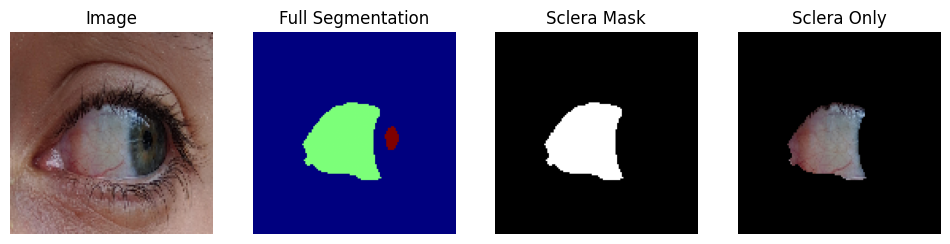

True

In [14]:
import matplotlib.pyplot as plt

sample = x_val[0:1]
pred = model.predict(sample)
pred_mask = np.argmax(pred[0], axis=-1)

# sclera = class 1
sclera_mask = (pred_mask == 1).astype(np.uint8)*255

# Apply the sclera mask to the original image
sclera_only = cv2.bitwise_and(sample[0], sample[0], mask=sclera_mask)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(sample[0]); plt.title("Image"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(pred_mask, cmap='jet'); plt.title("Full Segmentation"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(sclera_mask, cmap='gray'); plt.title("Sclera Mask"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(sclera_only); plt.title("Sclera Only"); plt.axis('off')
plt.show()

cv2.imwrite("sclera_predicted.png", sclera_mask)
cv2.imwrite("sclera_only.png", cv2.cvtColor(sclera_only, cv2.COLOR_RGB2BGR))

Mean Intensity: 15.63, Std: 46.67
Adaptive threshold = 0.100


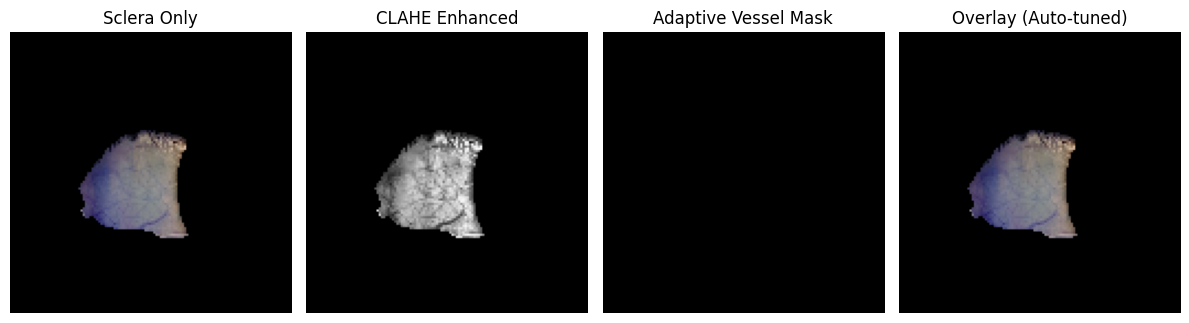

True

In [ ]:
sclera = cv2.cvtColor(sclera_only, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2GRAY)

# Step 1: Contrast enhancement (CLAHE)
gray = cv2.cvtColor(sclera, cv2.COLOR_RGB2GRAY)
gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# --- Step 1: Analyze brightness/contrast ---
mean_intensity = np.mean(gray)
std_intensity = np.std(gray)
print(f"Mean Intensity: {mean_intensity:.2f}, Std: {std_intensity:.2f}")

# Auto-tune CLAHE strength based on brightness
clip = 2.0 if mean_intensity > 110 else 4.0
clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
enhanced = clahe.apply(gray)

# --- Step 2: Vessel enhancement (Frangi) ---
vessels = frangi(enhanced / 255.0, sigmas=range(1, 5))
vessels_norm = (vessels - vessels.min()) / (vessels.max() - vessels.min() + 1e-6)

# --- Step 3: Adaptive threshold selection ---
# compute median intensity to adaptively set threshold
median_val = np.median(vessels_norm)
adaptive_thr = np.clip(median_val * 1.5, 0.1, 0.35)
print(f"Adaptive threshold = {adaptive_thr:.3f}")

vessel_mask = (vessels_norm > adaptive_thr).astype(np.uint8) * 255

# --- Step 4: Morphological cleanup ---
kernel = np.ones((3,3), np.uint8)
vessel_mask = cv2.morphologyEx(vessel_mask, cv2.MORPH_OPEN, kernel, iterations=1)
vessel_mask = cv2.dilate(vessel_mask, kernel, iterations=1)

# --- Step 5: Overlay vessels on sclera ---
overlay = sclera.copy()
overlay[vessel_mask > 0] = [255, 0, 0]  # red overlay

# --- Step 6: Display results ---
plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(sclera); plt.title("Sclera Only"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(enhanced, cmap='gray'); plt.title("CLAHE Enhanced"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(vessel_mask, cmap='gray'); plt.title("Adaptive Vessel Mask"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(overlay); plt.title("Overlay (Auto-tuned)"); plt.axis('off')
plt.tight_layout()
plt.show()

# Save
cv2.imwrite("adaptive_vessel_mask.png", vessel_mask)
cv2.imwrite("adaptive_vessel_overlay.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

## Prediction block

This is for handling only prediction.

✅ Model loaded from Model/sclera_iris_segmentation_model.h5


I0000 00:00:1761976398.325942   14123 service.cc:145] XLA service 0x7c48bc010cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761976398.326083   14123 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-01 01:53:18.384223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-01 01:53:18.735177: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1761976401.274235   14123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


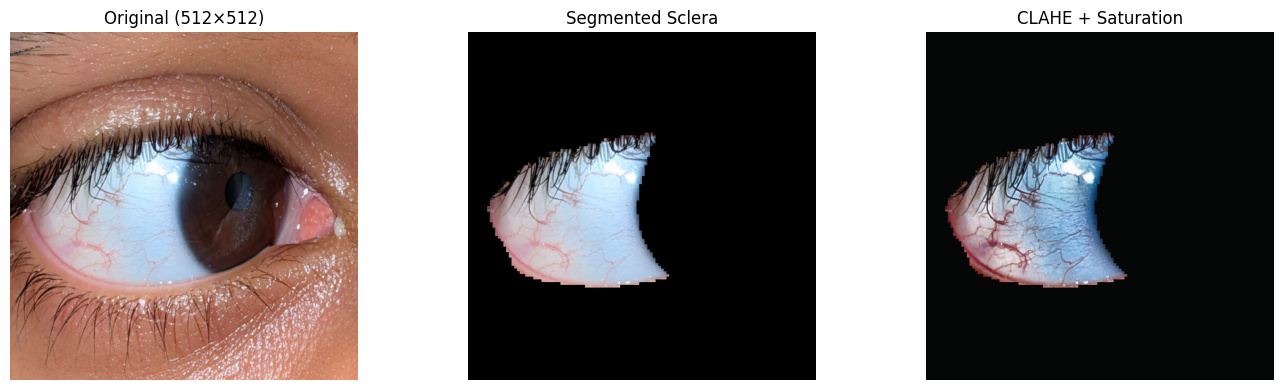

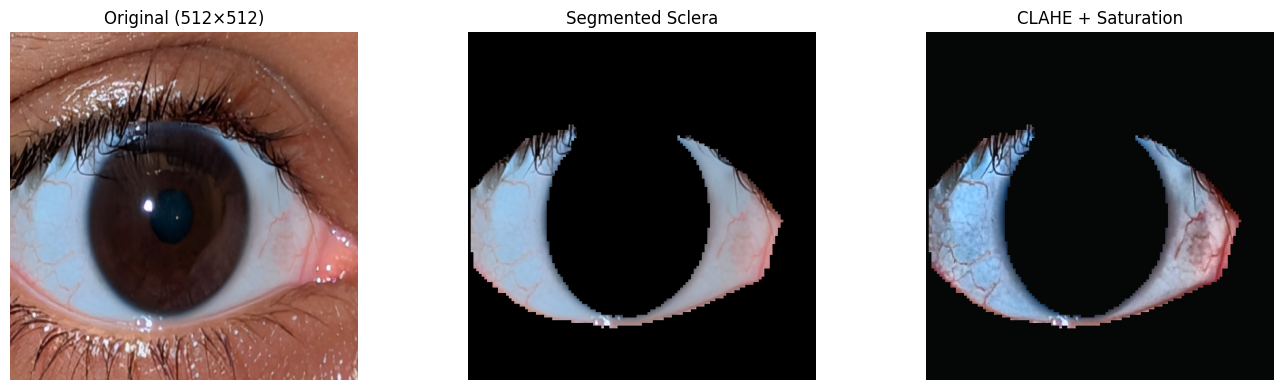

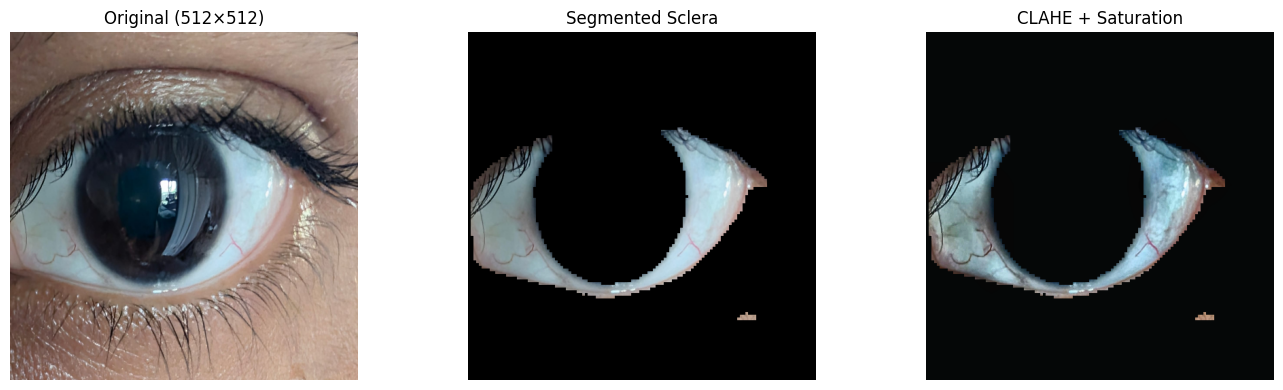

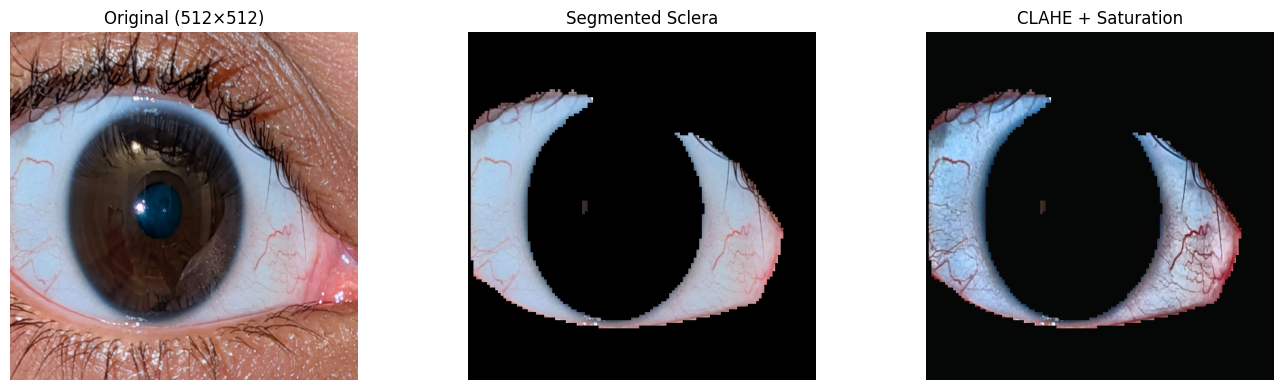

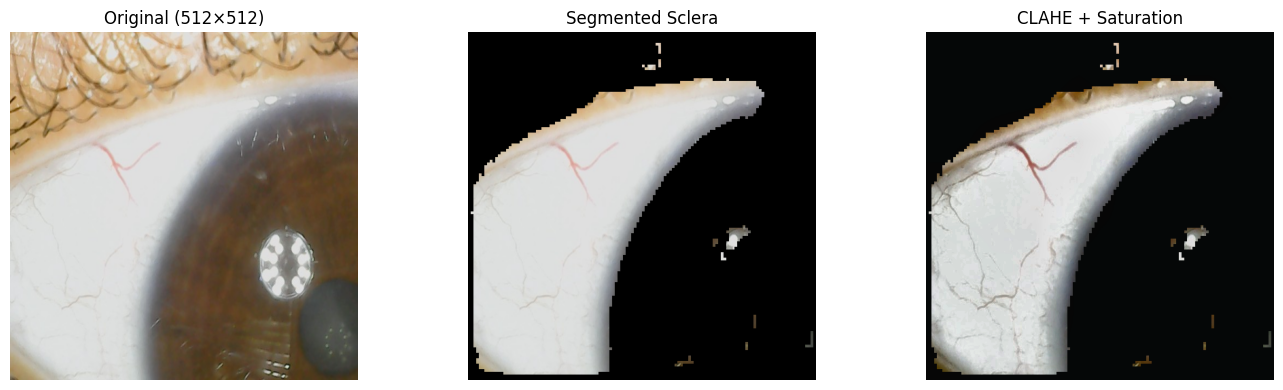

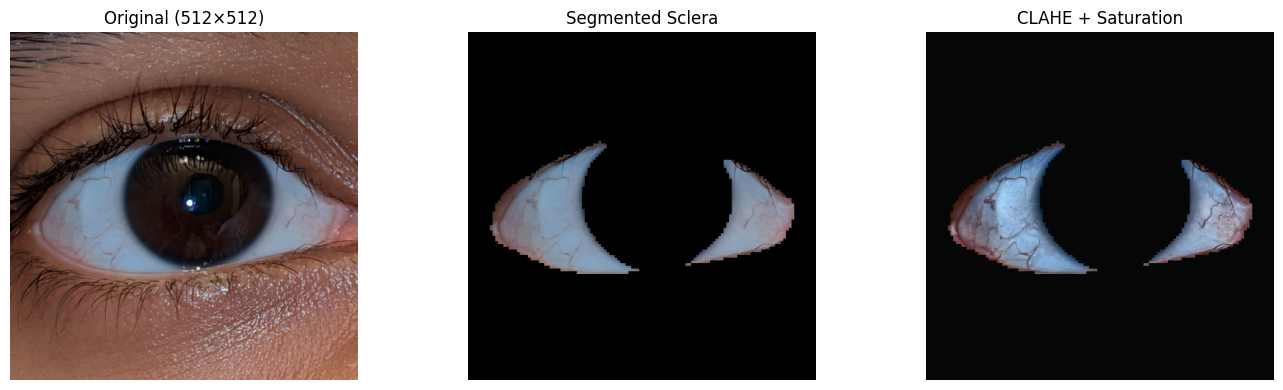

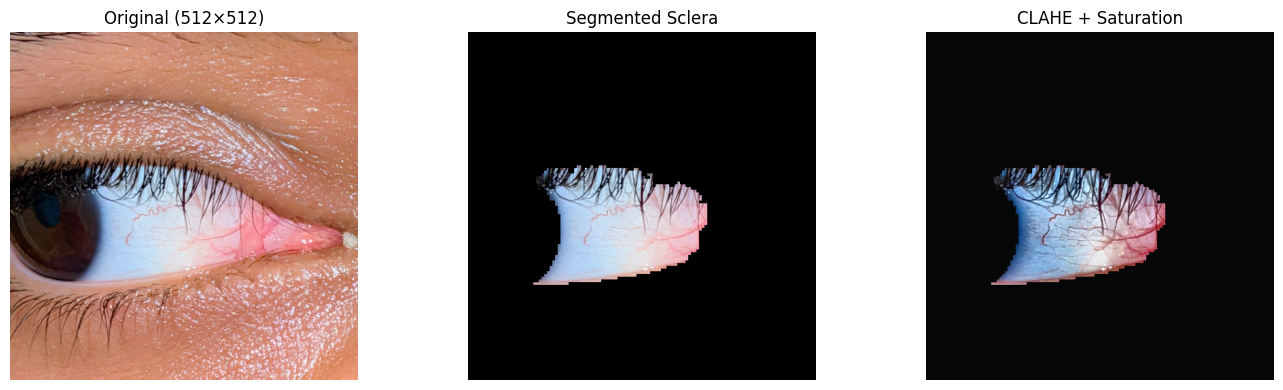

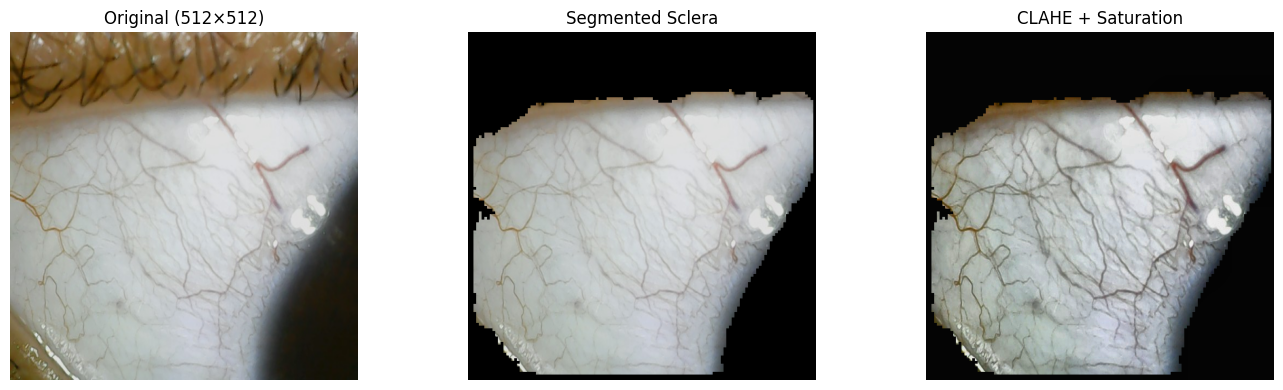

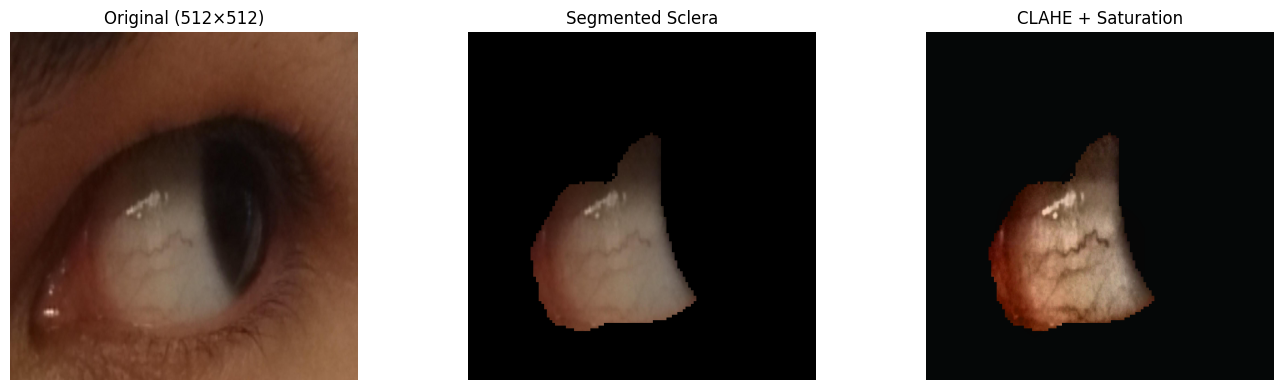

In [5]:
MODEL_PATH = "Model/sclera_iris_segmentation_model.h5"
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded from", MODEL_PATH)



def suppress_eyelash_edges(sobel_mag, top_trim=0.12, bottom_trim=0.12):
    """
    Suppresses strong edges from eyelashes or eyelids by masking 
    out the top and bottom bands of the sclera region, while keeping
    the central ellipse intact for vessel detection.
    """
    h, w = sobel_mag.shape

    # Step 1: Elliptical core mask (keeps most of sclera)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.ellipse(mask, (w//2, h//2), 
                (int(w*0.46), int(h*0.38)), 
                0, 0, 360, 255, -1)

    # Step 2: Explicitly zero-out top/bottom eyelash zones
    top = int(h * top_trim)
    bottom = int(h * (1 - bottom_trim))
    mask[:top, :] = 0
    mask[bottom:, :] = 0

    # Step 3: Apply mask
    masked = cv2.bitwise_and(sobel_mag, sobel_mag, mask=mask)

    # Optional: mild morphological closing to reconnect veins cut at edges
    kernel = np.ones((3,3), np.uint8)
    masked = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel, iterations=1)

    return masked

# -------------------------------
# 2. Prediction helper
# -------------------------------
def predict_sclera_and_vessels(image_path, save_dir="results",
                               seg_size=(128,128), full_size=(512,512),
                               sat_boost=1.4, clip_high=4.0, clip_low=2.0):
    """
    Segments the sclera, stretches the mask to full_size (e.g. 512×512),
    applies CLAHE for local contrast and boosts saturation.

    No edge detection or vessel filtering — lets the model learn features directly.
    """
    os.makedirs(save_dir, exist_ok=True)

    # --- Load image ---
    img_bgr = image_path
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_full = cv2.resize(img_rgb, full_size)

    # --- Segment sclera (low-res) ---
    img_small = cv2.resize(img_rgb, seg_size)
    inp = np.expand_dims(img_small / 255.0, axis=0)
    pred = model.predict(inp, verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1)

    # --- Stretch mask to full resolution ---
    mask_resized = cv2.resize(pred_mask.astype(np.uint8), full_size,
                              interpolation=cv2.INTER_NEAREST)

    # --- Extract sclera region ---
    sclera_mask = (mask_resized == 1).astype(np.uint8) * 255
    sclera_only = cv2.bitwise_and(img_full, img_full, mask=sclera_mask)

    # --- CLAHE for local contrast ---
    gray = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2GRAY)
    mean_intensity = np.mean(gray)
    clip = clip_low if mean_intensity > 110 else clip_high
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    L = clahe.apply(gray)

    # --- Replace L channel in LAB with enhanced one for natural contrast boost ---
    lab = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2LAB)
    L_orig, A, B = cv2.split(lab)
    lab_enh = cv2.merge([L, A, B])
    sclera_clahe = cv2.cvtColor(lab_enh, cv2.COLOR_LAB2RGB)

    # --- Saturation boost (emphasize subtle red veins) ---
    hsv = cv2.cvtColor(sclera_clahe, cv2.COLOR_RGB2HSV)
    hsv[...,1] = cv2.multiply(hsv[...,1], sat_boost)
    hsv[...,1] = np.clip(hsv[...,1], 0, 255)
    sclera_sat = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # ---------------------------------------------------
    # Visualization
    # ---------------------------------------------------
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.imshow(img_full); plt.title("Original (512×512)"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(sclera_only); plt.title("Segmented Sclera"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(sclera_sat); plt.title("CLAHE + Saturation"); plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Return the simple saturated sclera image
    return sclera_sat



# ---------------------------------------------------
# 3. Run on test images
# ---------------------------------------------------
TEST_DIR = "Tests/"   # folder containing new eye images
if os.path.isdir(TEST_DIR):
    # Process all images in the directory
    for f in os.listdir(TEST_DIR):
        if f.lower().endswith((".jpg", ".png", ".jpeg")):
            image_path = os.path.join(TEST_DIR, f)
            image_path = cv2.imread(image_path)
            if image_path is None:
                print(f"File does not exist: {image_path}")
                continue
            predict_sclera_and_vessels(image_path, save_dir="results")
else:
    # Process a single image file
    predict_sclera_and_vessels(TEST_DIR, save_dir="results")



## Siamese model

We now need to make the matching model. Now for this we will be using our `predict_sclera_and_vessls` method. We will use the file name to understand how to setup the dataset. The requirements of the dataset is as follows:

- The dataset will contain 2 classes `YES` and `NO`
- The classes are made by using the MOBIUS dataset itself. 

For this we need to udnerstand the naming schema of the image. Example: `1_1i_Ll_1.jpg`

In this `i_1i` is the name of the person and for `_Ll_1` is showing where the person is looking where the first letter 'L' is for the eye being left or right and small 'l' is for whether the person is looking left, right, up or straight. 

So for making dataseet it needs to follow:
- YES : uses the 1_li_L as a sequence to match others of the same name and uses the remaining part to basicaully give the model to match a person even if he looks left right or up or straight. 

- NO : Any image that don't match the initial name sequence 

2_1i_Ll_2.jpg: variance=15.01, blurry=True
2_2n_Rs_1.jpg: variance=46.12, blurry=False
2_1p_Lu_2.jpg: variance=15.70, blurry=True
2_1n_Ru_2.jpg: variance=14.81, blurry=True
2_3i_Ru_1.jpg: variance=150.76, blurry=False
2_2p_Rl_2.jpg: variance=133.37, blurry=False
2_2i_Ru_2.jpg: variance=82.47, blurry=False
2_3p_Rs_bad.jpg: variance=124.16, blurry=False
2_3p_Ru_1.jpg: variance=139.15, blurry=False
2_2i_Rl_1.jpg: variance=75.50, blurry=False
2_1i_Ll_1.jpg: variance=14.14, blurry=True
2_1p_Ls_2.jpg: variance=15.60, blurry=True
2_3i_Ru_2.jpg: variance=170.71, blurry=False
2_2p_Ls_2.jpg: variance=131.03, blurry=False
2_2p_Ll_1.jpg: variance=126.26, blurry=False
2_3p_Lu_bad.jpg: variance=165.93, blurry=False
2_2p_Ru_bad.jpg: variance=189.03, blurry=False
2_3n_Rl_2.jpg: variance=69.93, blurry=False
2_1p_Ls_bad.jpg: variance=14.06, blurry=True
2_1p_Rl_bad.jpg: variance=16.90, blurry=True
2_2i_Lu_2.jpg: variance=59.67, blurry=False
2_3p_Lu_1.jpg: variance=182.62, blurry=False
2_3p_Rr_2.jpg: vari

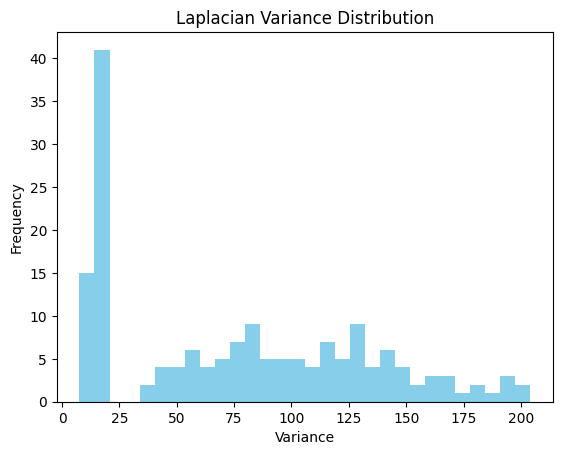

In [23]:
#### setting the right threshold for siamese evaluation
import os, random, cv2
import numpy as np
from itertools import combinations
from tqdm import tqdm

def is_blurry(img, threshold=20):
    """
    Returns True if the image is blurry based on Laplacian variance.
    Works on grayscale or color images.
    """
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    variance = cv2.Laplacian(gray, cv2.CV_64F, ksize=3).var()
    return variance < threshold, variance



variances = []
for f in os.listdir("MOBIUS/Images/2"):
    img = cv2.imread(os.path.join("MOBIUS/Images/2", f))
    if img is None:
        continue
    blurry, var = is_blurry(img, threshold=20)
    variances.append(var)
    print(f"{f}: variance={var:.2f}, blurry={blurry}")

plt.hist(variances, bins=30, color='skyblue')
plt.title("Laplacian Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()

Analyzing sharpness (Sobel) |████████████████████████████████████████| 168/168 [100%] in 17.8s (9.44/s) 


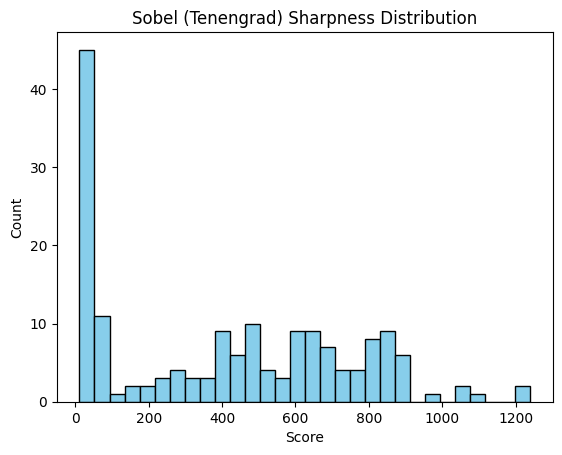

Median score: 433.8


In [24]:
import alive_progress as ap
def unsharp_mask(img, strength=1.5, blur_size=(3,3)):
    """
    Simple unsharp masking for mild blur.
    strength > 1.0 increases sharpness.
    """
    blur = cv2.GaussianBlur(img, blur_size, 0)
    sharp = cv2.addWeighted(img, 1 + strength, blur, -strength, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)


def is_blurry_sobel(img, threshold=200):
    """
    Returns (is_blurry, sharpness_score)
    Uses Sobel (Tenengrad) method to measure edge sharpness.
    Works on grayscale or color images.
    """
    if img is None:
        return True, 0.0

    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = unsharp_mask(gray, strength=1.5, blur_size=(3,3))
    else:
        gray = img
        gray = unsharp_mask(gray, strength=1.5, blur_size=(3,3))

    # Compute Sobel gradients in X and Y
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Gradient magnitude (edge strength)
    magnitude = np.sqrt(gx**2 + gy**2)

    # Tenengrad focus measure = mean of squared gradients
    score = np.mean(magnitude**2)

    return score < threshold, score

# variances = []
# for f in os.listdir("MOBIUS/Images/2"):
#     path = os.path.join("MOBIUS/Images/2", f)
#     img = cv2.imread(path)
#     if img is None:
#         continue

#     blurry, score = is_blurry_sobel(img, threshold=200)
#     variances.append(score)
#     print(f"{f}: score={score:.2f}, blurry={blurry}")

# print("Determining distribution of Sobel (Tenengrad) sharpness scores...")

scores = []
files = os.listdir("MOBIUS/Images/2")

with ap.alive_bar(len(files), title="Analyzing sharpness (Sobel)") as bar:
    for f in files:
        path = os.path.join("MOBIUS/Images/2", f)
        img = cv2.imread(path)
        if img is None:
            bar()  # still advance the bar even if skipped
            continue

        _, s = is_blurry_sobel(img)
        scores.append(s)

        bar() 

plt.hist(scores, bins=30, color='skyblue', edgecolor='black')
plt.title("Sobel (Tenengrad) Sharpness Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()
print(f"Median score: {np.median(scores):.1f}")

# root_dir = "MOBIUS/Images"
# folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])

# # Count total images
# total_images = sum(
#     len([x for x in os.listdir(os.path.join(root_dir, f)) if x.lower().endswith(('.jpg', '.png'))])
#     for f in folders
# )

# folder_scores = []

# # --- Hybrid progress setup ---
# with ap.alive_bar(len(folders), title="Analyzing Sobel Sharpness", bar="smooth", spinner="dots_waves2") as bar:
#     for folder in folders[:10]:
#         subdir = os.path.join(root_dir, folder)
#         scores = []
#         file_list = [f for f in os.listdir(subdir) if f.lower().endswith(('.jpg', '.png'))]

#         for f in file_list:
#             path = os.path.join(subdir, f)
#             img = cv2.imread(path)
#             if img is None:
#                 bar()
#                 continue

#             _, s = is_blurry_sobel(img)
#             scores.append(s)
#             bar.text(f"Folder {folder}: {s:.1f}")
#             bar()

#         median_score = np.median(scores) if scores else 0.0
#         folder_scores.append((folder, median_score))
#         print(f"[{folder}] Median Sobel sharpness: {median_score:.2f}")

# # --- Visualization ---
# folders, scores = zip(*folder_scores)
# median_threshold = np.median(scores)

# colors = ['red' if s < median_threshold else 'skyblue' for s in scores]

# plt.figure(figsize=(12, 6))
# plt.bar(folders, scores, color=colors, edgecolor='black')
# plt.axhline(median_threshold, color='gray', linestyle='--', label=f"Median={median_threshold:.1f}")
# plt.title("Median Sobel Sharpness per Folder")
# plt.xlabel("Folder (Person ID)")
# plt.ylabel("Median Sharpness Score")
# plt.xticks(rotation=90)
# plt.legend()
# plt.tight_layout()
# plt.show()

# print(f"\n📊 Overall median sharpness: {median_threshold:.2f}")

In [6]:
import cv2
import numpy as np

def sift_similarity(images, ratio_thresh=0.75, visualize=False):
    """
    Computes SIFT-based similarity between 2 or more RGB images.

    Parameters
    ----------
    images : list[np.ndarray]
        List of RGB images (each H×W×3, dtype uint8 or float32 [0–1]).
    ratio_thresh : float
        Lowe’s ratio test threshold for match filtering (default=0.75).
    visualize : bool
        If True and exactly two images are given, returns a match visualization image.

    Returns
    -------
    result : dict
        {
          'pair_scores': [(i, j, score, mean_distance, num_matches, num_kp_i, num_kp_j), ...],
          'mean_score': float,
          'visual': (optional) match image if visualize=True and len(images)==2
        }
    """

    if len(images) < 2:
        raise ValueError("Need at least 2 images for SIFT comparison.")

    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    pair_results = []
    vis_img = None

    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            img1 = images[i]
            img2 = images[j]

            # Convert to grayscale
            if img1.ndim == 3:
                img1_gray = cv2.cvtColor((img1 * 255).astype(np.uint8) if img1.max() <= 1 else img1, cv2.COLOR_RGB2GRAY)
            else:
                img1_gray = img1
            if img2.ndim == 3:
                img2_gray = cv2.cvtColor((img2 * 255).astype(np.uint8) if img2.max() <= 1 else img2, cv2.COLOR_RGB2GRAY)
            else:
                img2_gray = img2

            # Detect keypoints and descriptors
            kp1, des1 = sift.detectAndCompute(img1_gray, None)
            kp2, des2 = sift.detectAndCompute(img2_gray, None)

            if des1 is None or des2 is None:
                pair_results.append((i, j, 0, 0, 0, len(kp1 or []), len(kp2 or [])))
                continue

            # KNN matching
            matches = bf.knnMatch(des1, des2, k=2)
            good_matches = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

            num_good = len(good_matches)
            score = num_good / max(len(kp1), len(kp2), 1)  # normalized score [0–1]
            mean_dist = np.mean([m.distance for m in good_matches]) if num_good > 0 else np.inf

            pair_results.append((i, j, score, mean_dist, num_good, len(kp1), len(kp2)))

            # Optional visualization
            if visualize and len(images) == 2:
                vis_img = cv2.drawMatches(
                    img1, kp1, img2, kp2, good_matches, None,
                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                )

    mean_score = np.mean([s[2] for s in pair_results]) if pair_results else 0.0

    result = {
        "pair_scores": pair_results,
        "mean_score": mean_score
    }
    if vis_img is not None:
        result["visual"] = vis_img

    return result


In [7]:
import os, re, random, cv2, numpy as np
from tqdm import tqdm

IMG_SIZE_SEG = (128,128)
FULL_SIZE    = (256,256)

# Allowed cross-gaze combos (lowercase gazes)
VALID_GAZE_COMBOS = [
    ('s','s'), ('l','l'), ('r','r'), ('u','u'),
    ('s','l'), ('s','r')
]


def enhance_veins(img_rgb, contrast_boost=1.5):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    L = clahe.apply(L)
    lab_enh = cv2.merge([L, A, B])
    img = cv2.cvtColor(lab_enh, cv2.COLOR_LAB2RGB)

    # --- Step 2: Global Contrast Boost (gamma + stretch) ---
    img_float = img.astype(np.float32) / 255.0
    mean = np.mean(img_float)
    img_boost = np.clip((img_float - mean) * contrast_boost + mean, 0, 1)
    img_boost = np.power(img_boost, 1.0 / contrast_boost)  # gamma adjust
    img_boost = (img_boost * 255).astype(np.uint8)

    # --- Step 3: Green–Red difference map (vein emphasis) ---
    r, g, b = cv2.split(img_boost)
    vein_map = cv2.subtract(g, r)
    vein_map = cv2.normalize(vein_map, None, 0, 255, cv2.NORM_MINMAX)

    # --- Step 4: Top-hat filtering for fine lines ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    veins = cv2.morphologyEx(vein_map, cv2.MORPH_TOPHAT, kernel)

    # --- Step 5: Merge enhancement overlay ---
    img_boost[..., 1] = cv2.addWeighted(img_boost[..., 1], 0.7, veins, 0.3, 0)

    return img_boost

def make_siamese_dataset_from_schema(
        img_root, seg_model,
        max_pos=300, max_neg=300,
        seed=42,
        sat_boost=1.4):
    """
    Build Siamese pairs using schema: {pid}_{flag}_{Eye}{gaze}_{idx}.(jpg|png)
      - pid like "1_3"
      - flag: exclude 'p' (blurry) and any "*_bad.*"
      - Eye: 'L' or 'R'
      - gaze: 's','l','r','u' (lowercased handling)
      - idx: 1 or 2 (same-gaze YES uses strictly _1 with _2)

    YES pairs:
      1) Same-gaze: (pid, eye, gaze) — pair idx=1 with idx=2
      2) Cross-gaze: only in VALID_GAZE_COMBOS, same (pid, eye)

    NO pairs:
      - same eye & gaze, but different pid
    """
    rng = random.Random(seed)

    # ---------- helpers ----------
    name_re = re.compile(
        r'^(\d+_\d+)([a-zA-Z])_([LR])([slruSLRU])_([12])\.(jpg|png)$',
        re.IGNORECASE
    )

    def parse_name(fname: str):
        """
        Returns (pid, flag, eye, gaze, idx) or None if not matching.
        """
        m = name_re.match(fname)
        if not m:
            return None
        pid   = m.group(1)                       # e.g., '1_3'
        flag  = m.group(2).lower()               # e.g., 'p' / 'n' etc.
        eye   = m.group(3).upper()               # 'L' or 'R'
        gaze  = m.group(4).lower()               # 's','l','r','u'
        idx   = int(m.group(5))                  # 1 or 2
        return pid, flag, eye, gaze, idx

    def is_bad(fname: str) -> bool:
        # Only present with 'p' sets, but we still defensively exclude
        return fname.lower().endswith('_bad.jpg') or fname.lower().endswith('_bad.png')

    def extract_sclera_basic(img_rgb):
        """
        Segment @128, stretch mask to 256, then saturation boost only.
        """
        # segment at 128
        img_small = cv2.resize(img_rgb, IMG_SIZE_SEG)
        inp = np.expand_dims(img_small / 255.0, axis=0)
        pred = seg_model.predict(inp, verbose=0)
        pred_mask = np.argmax(pred[0], axis=-1).astype(np.uint8)

        # stretch mask to 256 and apply
        mask_resized = cv2.resize(pred_mask, FULL_SIZE, interpolation=cv2.INTER_NEAREST)
        img_full = cv2.resize(img_rgb, FULL_SIZE)
        sclera_mask = (mask_resized == 1).astype(np.uint8) * 255
        sclera_only = cv2.bitwise_and(img_full, img_full, mask=sclera_mask)

        # saturation boost
        hsv = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2HSV)
        hsv[..., 1] = cv2.multiply(hsv[..., 1], sat_boost)
        hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)
        sclera_sat = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        sclera_sat = enhance_veins(sclera_sat)
        return sclera_sat

    # ---------- index files ----------
    # Structure: data[pid][eye][gaze] -> {1: path, 2: path} (indices optional)
    data = {}
    all_by_eye_gaze = {}   # for NO pairs: (eye,gaze) -> [(pid, path)]
    total_files = 0

    for sub in sorted(os.listdir(img_root)):
        subdir = os.path.join(img_root, sub)
        if not os.path.isdir(subdir):
            continue
        for f in os.listdir(subdir):
            fl = f.lower()
            if not (fl.endswith('.jpg') or fl.endswith('.png')):
                continue
            if is_bad(f):
                continue

            parsed = parse_name(f)
            if not parsed:
                continue

            pid, flag, eye, gaze, idx = parsed
            if flag == 'p':  # exclude blurry flag
                continue

            full_path = os.path.join(subdir, f)

            # fill main data
            data.setdefault(pid, {}).setdefault(eye, {}).setdefault(gaze, {})[idx] = full_path
            # for NO pairs bucket
            all_by_eye_gaze.setdefault((eye, gaze), []).append((pid, full_path))
            total_files += 1

    print(f"Indexed files (after filtering): {total_files}")
    print(f"People found: {len(data)}")

    # ---------- build YES ----------
    X1, X2, y = [], [], []
    pos_cnt = 0
    print("✅ Building YES pairs (same person, same eye, valid gaze combos)…")

    with tqdm(total=max_pos, desc="YES pairs", dynamic_ncols=True) as pbar:
        for pid, eyes in data.items():
            for eye, gazes in eyes.items():
                # 1) same-gaze pairs: use _1 with _2
                for gaze, idx_map in gazes.items():
                    if ('s', gaze) not in VALID_GAZE_COMBOS and (gaze, gaze) not in VALID_GAZE_COMBOS:
                        # Only proceed if same-gaze allowed (it is, for s,s l,l r,r u,u)
                        pass
                    if 1 in idx_map and 2 in idx_map and ('%s' % gaze, '%s' % gaze) in VALID_GAZE_COMBOS:
                        if pos_cnt >= max_pos: break
                        f1, f2 = idx_map[1], idx_map[2]
                        try:
                            ia = cv2.cvtColor(cv2.imread(f1), cv2.COLOR_BGR2RGB)
                            ib = cv2.cvtColor(cv2.imread(f2), cv2.COLOR_BGR2RGB)
                            ia = extract_sclera_basic(ia)
                            ib = extract_sclera_basic(ib)
                            score = sift_similarity([ia, ib], ratio_thresh=0.75)
                            if score['mean_score'] < 0.2:
                                # very low similarity, likely bad pair
                                continue
                            X1.append(ia)
                            X2.append(ib)
                            y.append(1)
                            pos_cnt += 1
                            pbar.update(1)
                        except Exception:
                            pass
                if pos_cnt >= max_pos: break

                # 2) cross-gaze pairs within VALID_GAZE_COMBOS for this (pid, eye)
                available_gazes = list(gazes.keys())
                for (g1, g2) in VALID_GAZE_COMBOS:
                    if pos_cnt >= max_pos: break
                    if g1 == g2:
                        continue  # same-gaze handled above via 1<->2
                    if g1 in available_gazes and g2 in available_gazes:
                        # pick any index that exists (prefer _1)
                        f1 = gazes[g1].get(1) or gazes[g1].get(2)
                        f2 = gazes[g2].get(1) or gazes[g2].get(2)
                        if f1 and f2:
                            try:
                                ia = cv2.cvtColor(cv2.imread(f1), cv2.COLOR_BGR2RGB)
                                ib = cv2.cvtColor(cv2.imread(f2), cv2.COLOR_BGR2RGB)
                                X1.append(extract_sclera_basic(ia))
                                X2.append(extract_sclera_basic(ib))
                                y.append(1)
                                pos_cnt += 1
                                pbar.update(1)
                            except Exception:
                                pass
                if pos_cnt >= max_pos:
                    break
            if pos_cnt >= max_pos:
                break

    # ---------- build NO ----------
    neg_cnt = 0
    print("🚫 Building NO pairs (same gaze & eye, different person)…")
    with tqdm(total=max_neg, desc="NO pairs", dynamic_ncols=True) as pbar:
        for (eye, gaze), items in all_by_eye_gaze.items():
            if neg_cnt >= max_neg:
                break
            if len(items) < 2:
                continue
            # shuffle and form pairs ensuring different pid
            rng.shuffle(items)
            for i in range(len(items)-1):
                if neg_cnt >= max_neg:
                    break
                pid1, f1 = items[i]
                # find a different pid partner
                for j in range(i+1, len(items)):
                    pid2, f2 = items[j]
                    if pid1 != pid2:
                        try:
                            ia = cv2.cvtColor(cv2.imread(f1), cv2.COLOR_BGR2RGB)
                            ib = cv2.cvtColor(cv2.imread(f2), cv2.COLOR_BGR2RGB)
                            
                            X1.append(extract_sclera_basic(ia))
                            X2.append(extract_sclera_basic(ib))
                            y.append(0)
                            neg_cnt += 1
                            pbar.update(1)
                        except Exception:
                            pass
                        break

    # ---------- pack ----------
    X1 = np.array(X1, np.float32) / 255.0
    X2 = np.array(X2, np.float32) / 255.0
    y  = np.array(y,  np.uint8)

    print(f"\n✅ Dataset Ready → YES={pos_cnt}, NO={neg_cnt}")
    print(f"Shapes → X1={X1.shape}, X2={X2.shape}, y={y.shape}")
    return X1, X2, y


In [8]:
X1, X2, y = make_siamese_dataset_from_schema("MOBIUS/Images", max_pos=1000, max_neg=1000, seg_model=model)
### we need to shuffle the dataset here
min_len = min(len(X1), len(X2), len(y))
X1, X2, y = X1[:min_len], X2[:min_len], y[:min_len]

# Create a single permutation and apply jointly
idx = np.arange(min_len)
np.random.shuffle(idx)

X1 = X1[idx]
X2 = X2[idx]
y = y[idx]

Indexed files (after filtering): 9530
People found: 300
✅ Building YES pairs (same person, same eye, valid gaze combos)…


YES pairs: 100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


🚫 Building NO pairs (same gaze & eye, different person)…


NO pairs: 100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]



✅ Dataset Ready → YES=1000, NO=1000
Shapes → X1=(2000, 256, 256, 3), X2=(2000, 256, 256, 3), y=(2000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1773484..1.1114758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25205797..1.2592776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27047434..1.117671].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23928943..1.2460532].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16273311..1.2122458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23957995..1.2404373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28

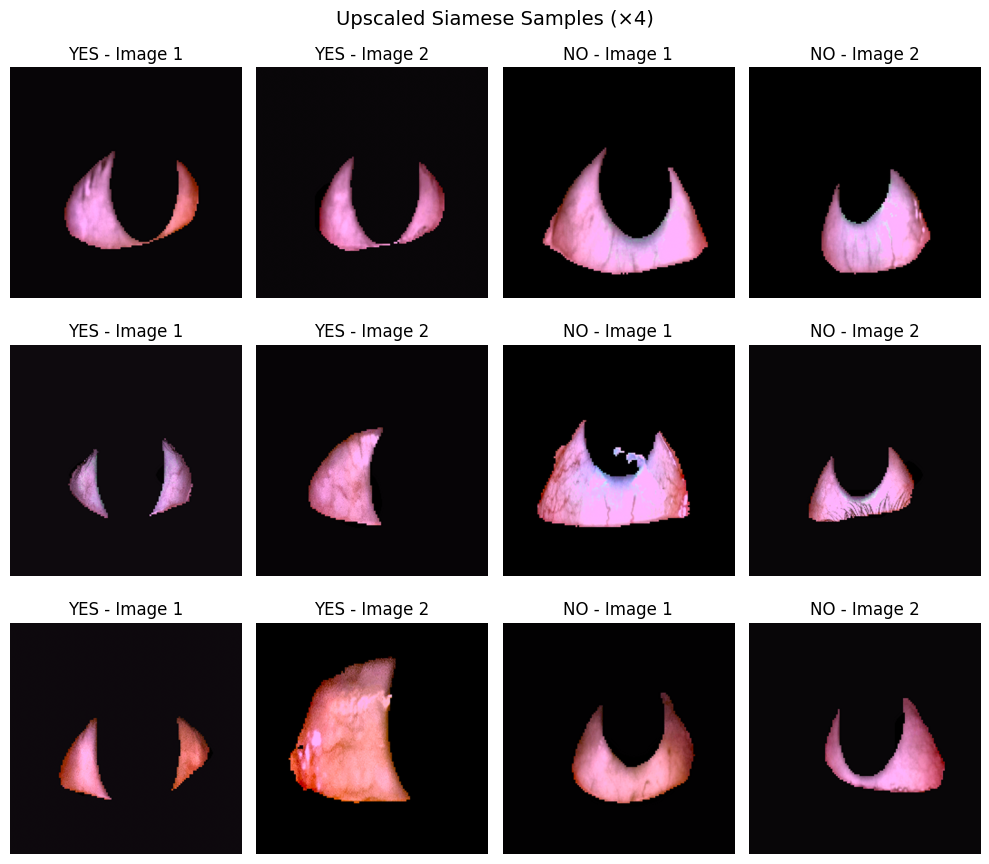

Final dataset shapes: (2000, 256, 256, 3) (2000, 256, 256, 3) (2000,)
Trimmed dataset to 2000 samples (consistent across X1, X2, y)


In [22]:
import matplotlib.pyplot as plt
import random



def show_siamese_samples(X1, X2, y, num_samples=3, upscale=2):
    """
    Displays example pairs from the Siamese dataset.
    Optionally upsamples images for clearer visualization (does NOT alter data).
    """
    yes_indices = [i for i, label in enumerate(y) if label == 1]
    no_indices = [i for i, label in enumerate(y) if label == 0]

    if not yes_indices or not no_indices:
        print("⚠️ Not enough YES/NO samples to display!")
        return

    plt.figure(figsize=(10, num_samples * 3))

    for n in range(num_samples):
        yes_idx = random.choice(yes_indices)
        no_idx = random.choice(no_indices)

        # Helper: upscale with bicubic interpolation
        def upscale_img(img):
            h, w = img.shape[:2]
            return cv2.resize(img, (w * upscale, h * upscale), interpolation=cv2.INTER_CUBIC)

        # YES pair
        plt.subplot(num_samples, 4, 4 * n + 1)
        plt.imshow(upscale_img(X1[yes_idx].squeeze()), cmap='gray')
        plt.title("YES - Image 1")
        plt.axis('off')

        plt.subplot(num_samples, 4, 4 * n + 2)
        plt.imshow(upscale_img(X2[yes_idx].squeeze()), cmap='gray')
        plt.title("YES - Image 2")
        plt.axis('off')

        # NO pair
        plt.subplot(num_samples, 4, 4 * n + 3)
        plt.imshow(upscale_img(X1[no_idx].squeeze()), cmap='gray')
        plt.title("NO - Image 1")
        plt.axis('off')

        plt.subplot(num_samples, 4, 4 * n + 4)
        plt.imshow(upscale_img(X2[no_idx].squeeze()), cmap='gray')
        plt.title("NO - Image 2")
        plt.axis('off')

    plt.suptitle(f"Upscaled Siamese Samples (×{upscale})", fontsize=14)
    plt.tight_layout()
    plt.show()

show_siamese_samples(X1, X2, y, num_samples=3, upscale=4)

min_len = min(len(X1), len(X2), len(y))
X1 = X1[:min_len]
X2 = X2[:min_len]
y  = y[:min_len]

print("Final dataset shapes:", X1.shape, X2.shape, y.shape)

print(f"Trimmed dataset to {min_len} samples (consistent across X1, X2, y)")

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def build_siamese_encoder(input_shape=(224,224,3)):
    inp = Input(shape=input_shape)

    # --- Block 1 ---
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # --- Block 2 ---
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # --- Block 3 ---
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # --- Dense projection ---
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(128, activation='relu')(x)
    return Model(inp, out, name="SiameseEncoder")


def build_siamese_network(input_shape=(256,256,3)):
    base_encoder = build_siamese_encoder(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    feat_a = base_encoder(input_a)
    feat_b = base_encoder(input_b)

    # Distance metric (L1 distance)
    diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([feat_a, feat_b])

    x = layers.Dense(64, activation='relu')(diff)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return Model([input_a, input_b], out, name="SiameseNetwork")



In [11]:
siamese_model = build_siamese_network()
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SiameseEncoder      │ (None, 128)       │    308,160 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ SiameseEncoder[0… │
│                     │                   │            │ SiameseEncoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 316,481 (1.21 MB)

 Trainable params: 315,777 (1.20 MB)

 Non-trainable params: 704 (2.75 KB)

In [12]:

# Fit
history = siamese_model.fit(
    [X1, X2], y,
    validation_split=0.2,
    epochs=20,
    batch_size=8,
    verbose=1
)

2025-10-31 17:38:17.635628: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1258291200 exceeds 10% of free system memory.
2025-10-31 17:38:20.139315: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1258291200 exceeds 10% of free system memory.
2025-10-31 17:38:21.506107: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1258291200 exceeds 10% of free system memory.
2025-10-31 17:38:22.142806: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1258291200 exceeds 10% of free system memory.


Epoch 1/20


2025-10-31 17:38:39.740141: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.6799 - loss: 0.6258 - val_accuracy: 0.4800 - val_loss: 0.7141
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7657 - loss: 0.5354 - val_accuracy: 0.7700 - val_loss: 0.5868
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7745 - loss: 0.5044 - val_accuracy: 0.7800 - val_loss: 0.5001
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7992 - loss: 0.4742 - val_accuracy: 0.8450 - val_loss: 0.4526
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8369 - loss: 0.4051 - val_accuracy: 0.8350 - val_loss: 0.4453
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8538 - loss: 0.3747 - val_accuracy: 0.8750 - val_loss: 0.3732
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8727 - loss: 0.3594 - val_accuracy: 0.8750 - val_loss: 0.3580
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8704 - loss: 0.3657 - val_accuracy: 0.88

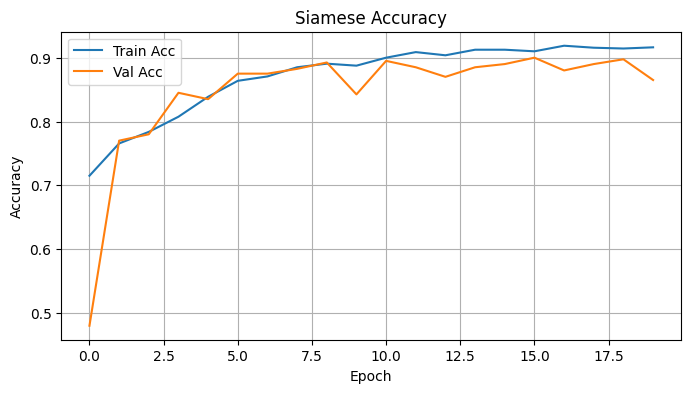

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Siamese Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

✅ Building YES pairs (same name used twice)…


YES pairs: 100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


🚫 Building NO pairs (same gaze, different name)…


NO pairs: 111it [00:44,  2.47it/s]                         



✅ Dataset Ready → YES=100, NO=100
Shapes → X1=(205, 256, 256, 3), X2=(200, 256, 256, 3), y=(200,)
🔍 Predicting on test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


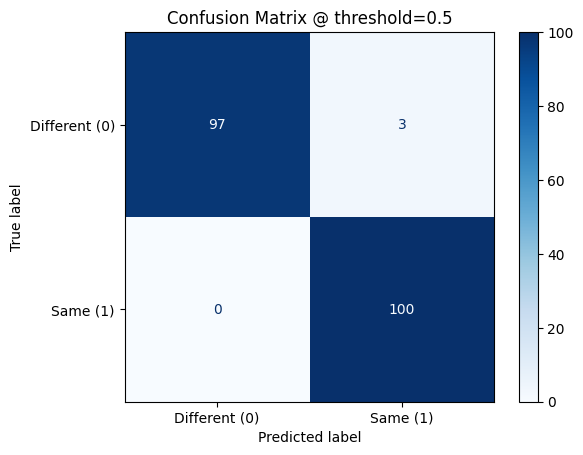


📊 Classification Report:
              precision    recall  f1-score   support

   Different       1.00      0.97      0.98       100
        Same       0.97      1.00      0.99       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

✅ Test Accuracy: 98.50%
TP: 100, TN: 97, FP: 3, FN: 0


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

def evaluate_siamese_on_test(model, X1_test, X2_test, y_test, threshold=0.5):
    """
    Evaluates Siamese network on test set and displays a confusion matrix.
    threshold = 0.5 for binary output (can tune using ROC later)
    """
    print("🔍 Predicting on test set...")
    y_pred_probs = model.predict([X1_test, X2_test])
    y_pred = (y_pred_probs > threshold).astype(int).flatten()

    # --- Confusion matrix ---
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Different (0)", "Same (1)"]
    )
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix @ threshold={threshold}")
    plt.show()

    # --- Classification report ---
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Different", "Same"]))

    # --- Basic metrics ---
    acc = np.mean(y_pred == y_test)
    print(f"✅ Test Accuracy: {acc*100:.2f}%")
    print(f"TP: {cm[1,1]}, TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}")

    return y_pred, cm

X1_test, X2_test, y_test = make_siamese_dataset_same_name_yes(
    "MOBIUS/Images", model,
    max_pos=100, max_neg=100,
    seed=1234)

min_len = min(len(X1_test), len(X2_test), len(y_test))
X1_test = X1_test[:min_len]
X2_test = X2_test[:min_len]
y_test  = y_test[:min_len]

y_pred, cm = evaluate_siamese_on_test(siamese_model, X1_test, X2_test, y_test)


In [20]:
model.save("Model/siamese_sclera_vessel_model.h5")

In [10]:
image1 = cv2.imread("Tests/test1.jpg")
image2 = cv2.imread("Tests/test2.jpg")
model =  tf.keras.models.load_model("Model/siamese_sclera_vessel_model.h5", compile=False)
print("✅ Siamese model loaded.")
### use make_siamese_dataset_from_mobius_hier's extract_vessels function to process images


[ WARN:0@153.419] global loadsave.cpp:248 findDecoder imread_('Tests/test1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@153.420] global loadsave.cpp:248 findDecoder imread_('Tests/test2.jpg'): can't open/read file: check file path/integrity


✅ Siamese model loaded.


### Test siamese model

In [11]:
import cv2, numpy as np
from skimage.filters import frangi

IMG_SIZE_SEG = (128,128)
FULL_SIZE = (256,256)

def prepare_siamese_input(img_path1, img_path2, seg_model, sobel_blur_threshold=20.0):
    """
    Prepares two input images for Siamese network inference.
    Exactly replicates the preprocessing in `make_siamese_dataset_same_name_yes`.
    
    Steps:
      - Sclera segmentation via seg_model (128x128)
      - Mask stretched to 256x256
      - CLAHE + Hybrid Frangi–Sobel enhancement
    Returns:
      (X1, X2): both with shape (1, 256, 256, 3)
    """

    # ---------- Blur detection ----------
    def is_blurry_sobel(img, threshold=20.0):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)
        variance = np.var(sobel_mag)
        return variance < threshold, variance

    # ---------- Vessel extraction ----------
    def extract_vessels_full(img_rgb):
        blur_flag, blur_score = is_blurry_sobel(img_rgb, sobel_blur_threshold)
        if blur_flag:
            raise ValueError(f"Blurry image (Sobel var={blur_score:.2f})")

        # Segmentation
        img_small = cv2.resize(img_rgb, IMG_SIZE_SEG)
        inp = np.expand_dims(img_small / 255.0, axis=0)
        pred = seg_model.predict(inp, verbose=0)
        pred_mask = np.argmax(pred[0], axis=-1)

        # Stretch mask to full resolution
        mask_resized = cv2.resize(pred_mask.astype(np.uint8), FULL_SIZE, interpolation=cv2.INTER_NEAREST)
        img_full = cv2.resize(img_rgb, FULL_SIZE)
        sclera_mask = (mask_resized == 1).astype(np.uint8) * 255
        sclera_only = cv2.bitwise_and(img_full, img_full, mask=sclera_mask)

        # CLAHE
        gray = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2GRAY)
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        mean_intensity = np.mean(gray)
        clip = 2.0 if mean_intensity > 110 else 4.0
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)

        # Sobel edges
        sobel_x = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=3)
        sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)
        sobel_mag = (sobel_mag / (sobel_mag.max() + 1e-6) * 255).astype(np.uint8)

        # Frangi
        fv = frangi(enhanced / 255.0, sigmas=range(1,5))
        fv = (fv - fv.min()) / (fv.max() - fv.min() + 1e-6)
        fv = (fv * 255).astype(np.uint8)

        # Fuse Frangi + Sobel
        fused = cv2.addWeighted(fv, 0.7, sobel_mag, 0.3, 0)
        fused_boost = cv2.bitwise_and(fv, sobel_mag)
        fused_final = cv2.addWeighted(fused, 0.8, fused_boost, 0.4, 0)

        # Threshold using Sobel
        blur = cv2.GaussianBlur(sobel_mag, (5,5), 0)
        _, vessel_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        overlay = sclera_only.copy()
        overlay[vessel_mask > 0] = [255, 0, 0]

        return overlay

    # ---------- Load and preprocess both images ----------
    img1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img_path2), cv2.COLOR_BGR2RGB)

    proc1 = extract_vessels_full(img1)
    proc2 = extract_vessels_full(img2)

    # ---------- Normalize for model input ----------
    X1 = np.expand_dims(proc1.astype(np.float32) / 255.0, axis=0)
    X2 = np.expand_dims(proc2.astype(np.float32) / 255.0, axis=0)

    return X1, X2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Siamese similarity score: 0.6 (1.0 = same, 0.0 = different)


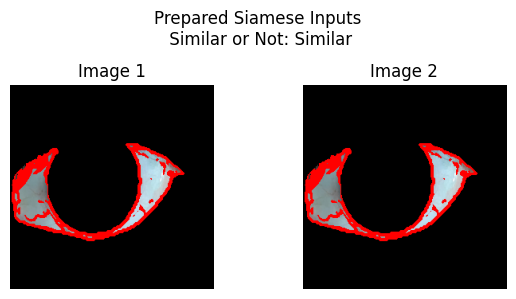

In [54]:
X1_test, X2_test = prepare_siamese_input(
    "Tests/test1.jpeg",
    "Tests/test1.jpeg",
    seg_model=model  # segmentation model
)

similarity = siamese_model.predict([X1_test, X2_test])
similarity = np.clip(similarity, 0.0, 1.0)
score = round(float(similarity[0, 0]), 1)  # ✅ round to 1 decimal place

print(f"Siamese similarity score: {score} (1.0 = same, 0.0 = different)")

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(X1_test[0].squeeze(), cmap='gray'); plt.title("Image 1"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(X2_test[0].squeeze(), cmap='gray'); plt.title("Image 2"); plt.axis('off')
plt.suptitle(f"Prepared Siamese Inputs\n Similar or Not: {"Similar" if score > 0.5 else "Different"}")
plt.tight_layout()
plt.show()

## Inception hybrid

we use inception to try and see if the model can learn patterns better. 

In [23]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import regularizers


def build_inception_siamese_contrastive(input_shape=(256,256,3), trainable=False):
    # Base encoder
    base_cnn = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    if not trainable:
        for layer in base_cnn.layers:
            layer.trainable = False

    x = base_cnn.get_layer("mixed7").output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    feat = layers.Dense(128, activation=None)(x)
    feat = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(feat)  # L2 normalize embeddings

    feature_extractor = Model(base_cnn.input, feat, name="InceptionEncoder")

    # Twin inputs
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)

    # L2 distance layer (no sigmoid)
    distance = layers.Lambda(lambda x: tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True))([feat_a, feat_b])

    siamese_model = Model([input_a, input_b], distance, name="InceptionSiameseContrastive")
    return siamese_model


def contrastive_loss(y_true, dist, margin=1.0):
    """
    Contrastive loss for L2 distances (not probabilities).
    """
    y_true = tf.cast(y_true, dist.dtype)
    pos_loss = y_true * tf.square(dist)  # similar -> small distance
    neg_loss = (1 - y_true) * tf.square(tf.maximum(margin - tf.sqrt(dist + 1e-6), 0))  # dissimilar -> large distance
    return tf.reduce_mean(pos_loss + neg_loss)


def contrastive_accuracy(y_true, y_pred, margin=1.0):
    """
    Measures accuracy based on whether the predicted distance
    correctly reflects same/different pairs.
    """
    y_true = tf.cast(y_true, y_pred.dtype)
    D = tf.sqrt(y_pred + 1e-6)
    # predict same if distance < margin/2, else different
    y_pred_class = tf.cast(D < (margin / 2), y_true.dtype)
    return tf.reduce_mean(tf.cast(tf.equal(y_pred_class, y_true), tf.float32))


# def build_inception_siamese(input_shape=(256,256,3), trainable=False):
#     base_cnn = tf.keras.applications.InceptionV3(
#         include_top=False, weights='imagenet', input_shape=input_shape
#     )
#     if not trainable:
#         for layer in base_cnn.layers:
#             layer.trainable = False

#     x = base_cnn.get_layer("mixed7").output
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.GaussianNoise(0.1)(x)
#     x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
#     x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)  # normalize embeddings

#     feature_extractor = Model(base_cnn.input, x, name="InceptionEncoder")

#     # Siamese inputs
#     input_a = Input(shape=input_shape)
#     input_b = Input(shape=input_shape)
#     feat_a = feature_extractor(input_a)
#     feat_b = feature_extractor(input_b)

#     diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([feat_a, feat_b])
#     x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(diff)
#     x = layers.Dropout(0.4)(x)
#     out = layers.Dense(1, activation='sigmoid')(x)

#     siamese = Model([input_a, input_b], out, name="InceptionSiamese")
#     return siamese

In [68]:
# siamese_model = build_inception_siamese(trainable=False)
# # siamese_model.compile(
# #     optimizer=tf.keras.optimizers.Adam(1e-4),
# #     loss=lambda y, y_pred: contrastive_loss(y, y_pred, margin=1.0),
# #     metrics=[lambda y, y_pred: contrastive_accuracy(y, y_pred, margin=1.0)]
# # )

# siamese_model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

siamese_model = build_inception_siamese_contrastive()

# siamese_model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss=lambda y, y_pred: contrastive_loss(y, y_pred, margin=1.0),
#     metrics=[]
# )

siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

siamese_model.summary()

Model: "InceptionSiameseContrastive"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InceptionEncoder    │ (None, 128)       │  9,205,024 │ input_layer_5[0]… │
│ (Functional)        │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ InceptionEncoder… │
│                     │                   │            │ InceptionEncoder… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,205,024 (35.11 MB)

 Trainable params: 229,760 (897.50 KB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [ ]:
history = siamese_model.fit(
    [X1, X2], y,
    validation_split=0.2,
    batch_size=16,
    epochs=20,
    verbose=1
)

2025-11-01 02:34:34.306406: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1258291200 exceeds 10% of free system memory.


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.4747 - loss: 1.2282 - val_accuracy: 0.4825 - val_loss: 2.1619
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5428 - loss: 0.7060 - val_accuracy: 0.4825 - val_loss: 2.1229
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5850 - loss: 0.6721 - val_accuracy: 0.4825 - val_loss: 2.0302
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6406 - loss: 0.6399 - val_accuracy: 0.4825 - val_loss: 1.8777
Epoch 5/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7063 - loss: 0.5864

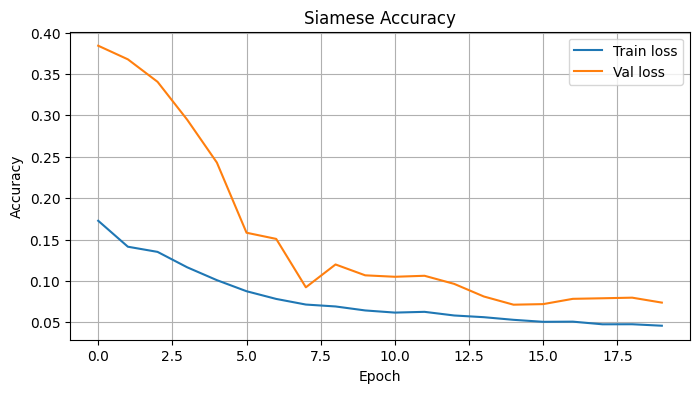

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
#plt.plot(history.history['val_lambda'], label='Val Acc')
plt.title('Siamese Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
def extract_sclera_basic(img_rgb, sat_boost=1.4, seg_model=None):
    """
    Segment @128, stretch mask to 256, then saturation boost + optional vein enhancement.
    Accepts either file path or RGB array.
    """
    # Handle path input
    if isinstance(img_rgb, str):
        img_rgb = cv2.cvtColor(cv2.imread(img_rgb), cv2.COLOR_BGR2RGB)

    # segment at 128
    img_small = cv2.resize(img_rgb, (128, 128))
    inp = np.expand_dims(img_small / 255.0, axis=0)
    pred = seg_model.predict(inp, verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1).astype(np.uint8)

    # stretch mask to 256 and apply
    mask_resized = cv2.resize(pred_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    img_full = cv2.resize(img_rgb, (256, 256))
    sclera_mask = (mask_resized == 1).astype(np.uint8) * 255
    sclera_only = cv2.bitwise_and(img_full, img_full, mask=sclera_mask)

    # saturation + contrast boost
    hsv = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = cv2.multiply(hsv[..., 1], sat_boost)
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)
    sclera_sat = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    sclera_sat = enhance_veins(sclera_sat)
    return sclera_sat


In [53]:
img1 = cv2.cvtColor(cv2.imread("Tests/30_3n_Ll_2.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("Tests/RightEye_S.jpeg"), cv2.COLOR_BGR2RGB)

X1_test = extract_sclera_basic(img1, seg_model=model)
X2_test = extract_sclera_basic(img2, seg_model=model)
#siamese_model = tf.keras.models.load_model("Model/siamese_inception_sclera_vessel_model.h5", compile=False)
# Add batch dimension
X1_test = np.expand_dims(X1_test, axis=0)
X2_test = np.expand_dims(X2_test, axis=0)

# Predict distance
dist = siamese_model.predict([X1_test, X2_test])
print("Predicted distance:", dist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted distance: [[0.02705025]]


In [54]:
siamese_model.save("Model/siamese_inception_sclera_vessel_model.h5")

### Sift approach

In [55]:
import cv2
import numpy as np

def compare_sift_similarity(img1_rgb, img2_rgb):
    """
    Compare two sclera-segmented RGB images using SIFT keypoints + FLANN matching.

    Returns
    -------
    match_ratio : float
        Ratio (0–1) of good matches to keypoints — higher means more similar.
    n_matches : int
        Number of good matches actually found.
    """

    # --- Convert to grayscale for SIFT ---
    gray1 = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)

    # --- Create SIFT detector ---
    sift = cv2.SIFT_create()

    # --- Detect and compute keypoints + descriptors ---
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # If no descriptors found in either, return 0 similarity
    if des1 is None or des2 is None or len(kp1) == 0 or len(kp2) == 0:
        return 0.0, 0

    # --- FLANN-based matcher (fast for float descriptors) ---
    index_params = dict(algorithm=1, trees=5)  # 1 = KDTree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # --- Find 2 nearest matches for ratio test ---
    matches = flann.knnMatch(des1, des2, k=2)

    # --- Lowe's ratio test to filter out ambiguous matches ---
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # --- Compute normalized similarity score ---
    n_matches = len(good_matches)
    min_kp = min(len(kp1), len(kp2))
    match_ratio = n_matches / (min_kp + 1e-6)

    # --- Clamp to [0, 1] ---
    match_ratio = float(np.clip(match_ratio, 0, 1))

    return match_ratio, n_matches


In [67]:
# Preprocess sclera first
img1 = extract_sclera_basic("Tests/test2.jpeg", seg_model=model)
img2 = extract_sclera_basic("Tests/test3.jpeg", seg_model=model)

# Compute SIFT similarity
similarity, good = compare_sift_similarity(img1, img2)

print(f"SIFT similarity: {similarity:.3f}  ({good} good matches)")
if similarity > 0.4:
    print("✅ Likely same person/eye")
else:
    print("❌ Likely different")

SIFT similarity: 0.000  (0 good matches)
❌ Likely different
